In [1]:
import pandas as pd
import numpy as np
import os
import random
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import torch.nn as nn
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils import data
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, models

In [2]:
train_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/train'
test_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/test'
val_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/val'

In [3]:
def class_size(path):
    for i in os.listdir(path):
        print(f'the {i} group has {len(os.listdir(os.path.join(path, i)))} images in the {path.split("/")[-1]} dataset\n')

In [4]:
class_size(train_dir)
class_size(val_dir)
class_size(test_dir)

the PNEUMONIA group has 3875 images in the train dataset

the NORMAL group has 1341 images in the train dataset

the PNEUMONIA group has 8 images in the val dataset

the NORMAL group has 8 images in the val dataset

the PNEUMONIA group has 390 images in the test dataset

the NORMAL group has 234 images in the test dataset



In [5]:
def plot_class_distribution(path):
    L = []
    for i in os.listdir(path):
        L.append((i, len(os.listdir(os.path.join(path, i)))))
    df = pd.DataFrame(L)
    df.columns = ['classes', 'count']

    color = ['#' + ''.join([random.choice('0123456789ABCDEF') for i in range(6)]) for i in range(df['classes'].nunique())]
    fig, axes = plt.subplots(1,2, figsize=(16,6))
    sns.barplot(data=df, x='classes', y='count',palette=color ,ax=axes[0])
    for i in axes[0].containers:
        axes[0].bar_label(i)
    axes[0].set_xlabel('')
    for l in axes[0].get_xticklabels():
        l.set_fontsize(10)
        l.set_weight('semibold')

    paches, text, pts = axes[1].pie(df['count'], 
                                    labels=df['classes'],
                                    autopct='%1.2f%%', 
                                    wedgeprops={'linewidth': 2, 'edgecolor': 'white'},
                                    textprops={'size': 'x-large'}, colors=color)

    for i in text:
        i.set_fontsize(10)
        i.set_weight('semibold')
    for num, i in enumerate(paches):
        text[num].set_color(i.get_facecolor())
    for i in pts:
        i.set_fontsize(10)

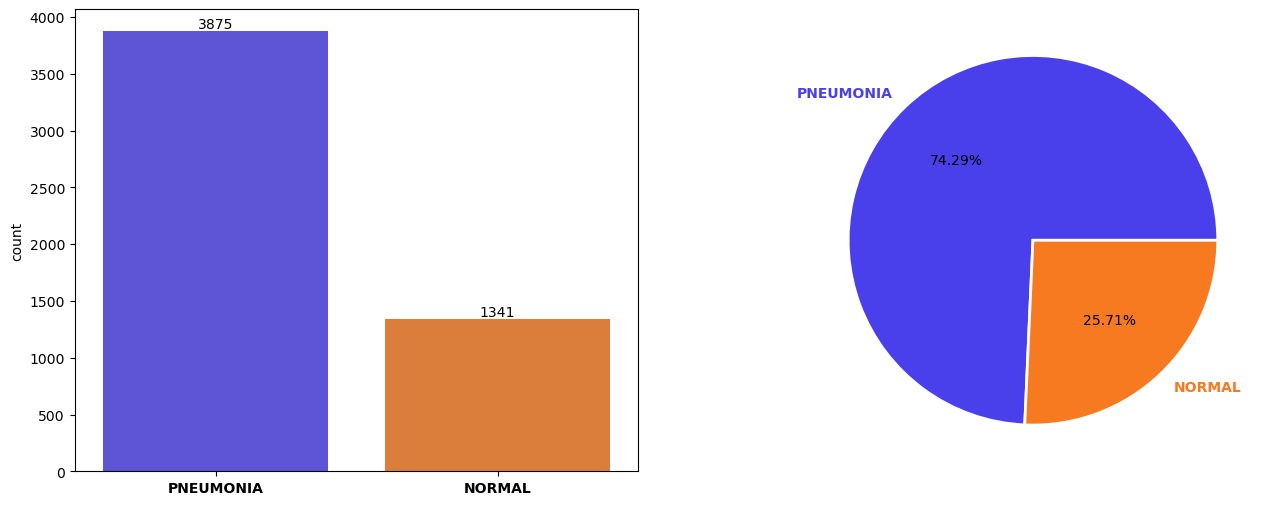

In [6]:
plot_class_distribution(train_dir)

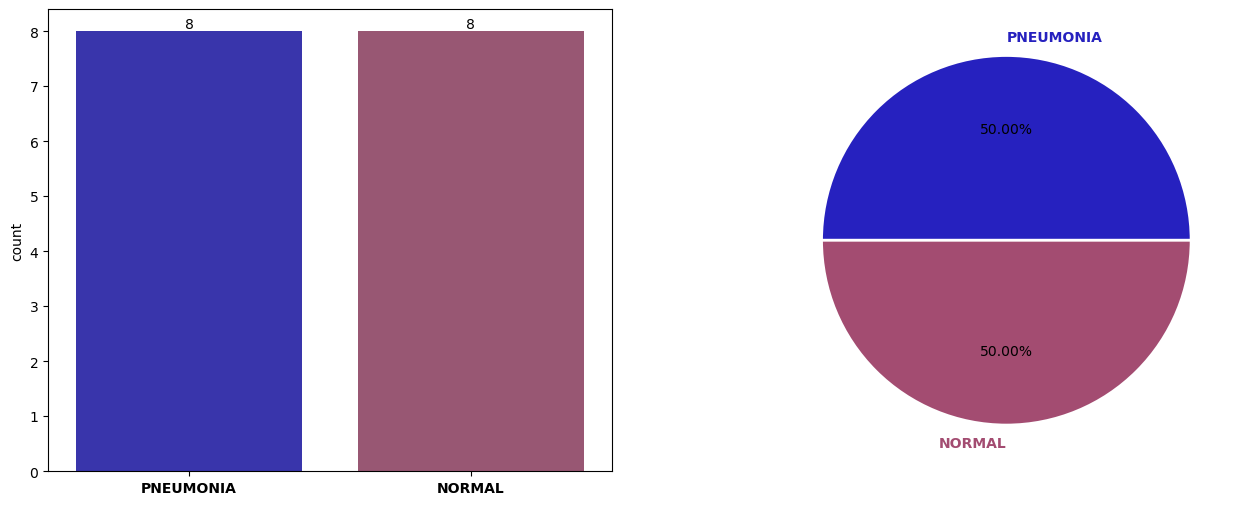

In [7]:
plot_class_distribution(val_dir)

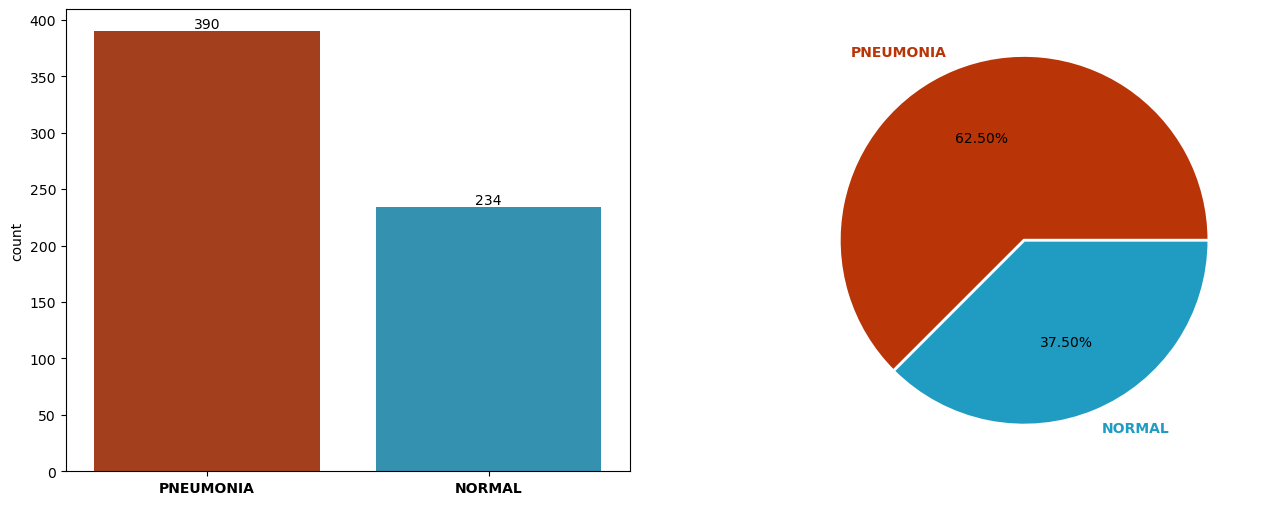

In [8]:
plot_class_distribution(test_dir)

### take a look at the sample pictures

In [9]:
def get_sample_images(path):
    for i in os.listdir(path):
        imgs = os.listdir(os.path.join(path, i))
        sample = random.sample(imgs, 6)
        fig, axes = plt.subplots(1,6, figsize=(20,4))
        for num, ax in enumerate(axes.flat):
            ax.imshow(plt.imread(os.path.join(path, i, sample[num])), cmap='gray')
            ax.set_title(i)
            ax.axis('off')

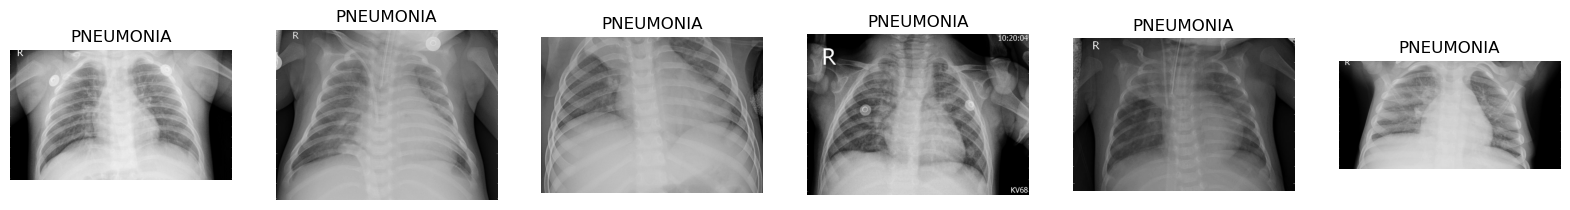

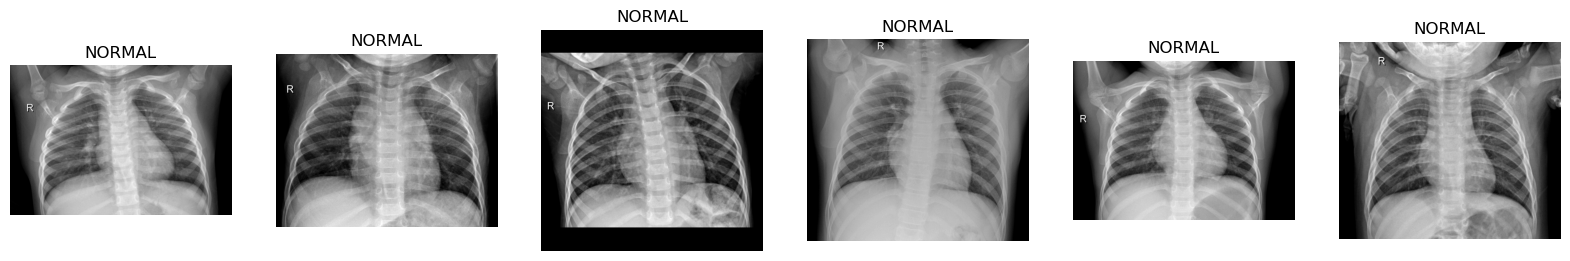

In [10]:
get_sample_images(train_dir)

### build a model with pytorch

In [11]:
transforms = transforms.Compose([transforms.Resize((72, 72)), 
                                 transforms.RandomHorizontalFlip(),
                                 transforms.RandomRotation(45),
                                 transforms.RandomRotation(135),
                                 transforms.RandomPerspective(),
                                 transforms.RandomCrop(64),
                                 transforms.RandomVerticalFlip(),
                                 transforms.RandomAffine(45),
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
train_data = torchvision.datasets.ImageFolder(root = train_dir, transform=transforms)
val_data = torchvision.datasets.ImageFolder(root = test_dir, transform=transforms)
test_data = torchvision.datasets.ImageFolder(root = val_dir, transform=transforms)

In [12]:
batch_size = 64
train_data_loader = data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_data_loader = data.DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_data_loader = data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [13]:
model_ft = models.resnet18()
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 2)

net = model_ft.to('cpu')

In [14]:
print(net)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [15]:
optimizer = optim.Adam(net.parameters(), lr= 0.00001, weight_decay=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=2, verbose=True)
lr_fn  = torch.nn.CrossEntropyLoss()

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
H = {"train_loss": [],"train_acc": [],"val_loss": [],"val_acc": []}
trainSteps = len(train_data_loader.dataset) // batch_size
valSteps = len(val_data_loader.dataset) // batch_size

In [17]:
for epoch in range(0, 20):
    net.train()
    train_loss = 0
    val_loss = 0
    train_correct = 0
    val_correct = 0
    for (x,y) in train_data_loader:
        (x,y) = (x.to(device), y.to(device))
        
        pred = net(x)
        loss = lr_fn(pred, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss
        train_correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    
    with torch.no_grad():
        net.eval()
        for (x1,y1) in val_data_loader:
            (x1, y1) = (x1.to(device), y1.to(device))
            pred1 = net(x1)
            val_loss += lr_fn(pred1, y1)
            val_correct += (pred1.argmax(1) == y1).type(torch.float).sum().item()
            
    avg_train_loss = train_loss/trainSteps
    avg_val_loss = val_loss/valSteps
    
    scheduler.step(avg_val_loss)
    
    train_correct = train_correct/len(train_data_loader.dataset)
    val_correct = val_correct/len(val_data_loader.dataset)
    
    H["train_loss"].append(avg_train_loss.cpu().detach().numpy())
    H["train_acc"].append(train_correct)
    H["val_loss"].append(avg_val_loss.cpu().detach().numpy())
    H["val_acc"].append(val_correct)
    
    print("[INFO] EPOCH: {}/{}".format(epoch + 1, 20))
    print("Train loss: {:.6f}, Train accuracy: {:.4f}".format(avg_train_loss, train_correct))
    print("Val loss: {:.6f},   Val accuracy: {:.4f}\n".format(avg_val_loss, val_correct))
    

[INFO] EPOCH: 1/20
Train loss: 0.522061, Train accuracy: 0.7439
Val loss: 0.590868,   Val accuracy: 0.6891

[INFO] EPOCH: 2/20
Train loss: 0.423048, Train accuracy: 0.7929
Val loss: 0.516492,   Val accuracy: 0.7612

[INFO] EPOCH: 3/20
Train loss: 0.350057, Train accuracy: 0.8447
Val loss: 0.436229,   Val accuracy: 0.8205

[INFO] EPOCH: 4/20
Train loss: 0.327112, Train accuracy: 0.8524
Val loss: 0.441342,   Val accuracy: 0.8125

[INFO] EPOCH: 5/20
Train loss: 0.299281, Train accuracy: 0.8702
Val loss: 0.437677,   Val accuracy: 0.8285

[INFO] EPOCH: 6/20
Train loss: 0.283413, Train accuracy: 0.8809
Val loss: 0.399672,   Val accuracy: 0.8574

[INFO] EPOCH: 7/20
Train loss: 0.274904, Train accuracy: 0.8815
Val loss: 0.424970,   Val accuracy: 0.8462

[INFO] EPOCH: 8/20
Train loss: 0.267073, Train accuracy: 0.8819
Val loss: 0.430254,   Val accuracy: 0.8253

Epoch 00009: reducing learning rate of group 0 to 5.0000e-06.
[INFO] EPOCH: 9/20
Train loss: 0.260048, Train accuracy: 0.8923
Val loss: 

In [18]:
import matplotlib.pyplot as plt

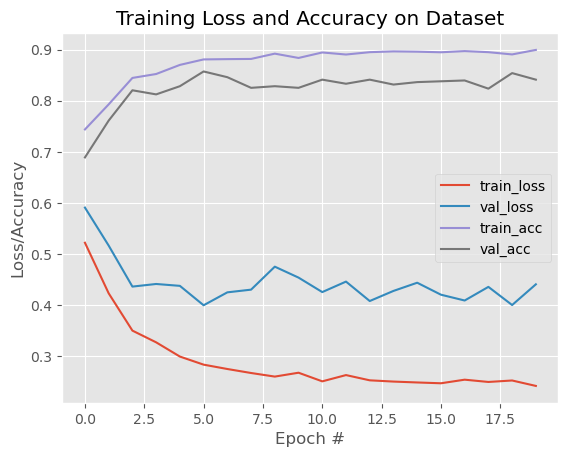

In [19]:
plt.style.use("ggplot")
plt.figure()
plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["val_loss"], label="val_loss")
plt.plot(H["train_acc"], label="train_acc")
plt.plot(H["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend();

### test the model

In [20]:
from sklearn.metrics import classification_report
import numpy as np

In [26]:
print("[INFO] evaluating network...")
# turn off autograd for testing evaluation
with torch.no_grad():
    # set the model in evaluation mode
    net.eval()

    # initialize a list to store our predictions
    preds = []
    # loop over the test set
    for (x, y) in val_data_loader:
        # send the input to the device
        x = x.to(device)
        # make the predictions and add them to the list
        pred = net(x)
        preds.extend(pred.argmax(axis=1).cpu().numpy())
        
# generate a classification report
print(classification_report(val_data.targets, np.array(preds), target_names=val_data.classes))

[INFO] evaluating network...
              precision    recall  f1-score   support

      NORMAL       0.90      0.68      0.77       234
   PNEUMONIA       0.83      0.96      0.89       390

    accuracy                           0.85       624
   macro avg       0.87      0.82      0.83       624
weighted avg       0.86      0.85      0.85       624



<Axes: >

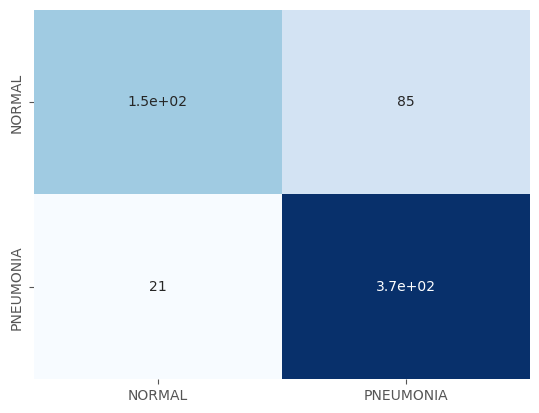

In [31]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd

y_pred = []
y_true = []

# iterate over test data
for inputs, labels in val_data_loader:
        output = net(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = ('PNEUMONIA','NORMAL')

# Build confusion matrix
cf_cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cf_cm, annot=True, cmap='Blues', cbar=False,xticklabels=val_data.classes, yticklabels=val_data.classes )